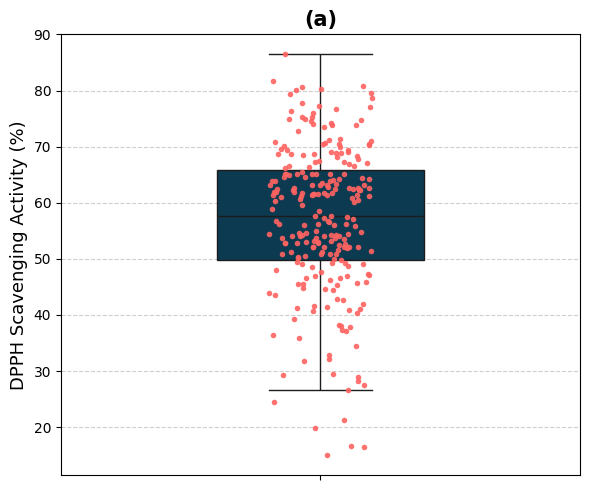

C:\Users\soura\AppData\Local\Temp\ipykernel_21228\109541991.py:85: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
C:\Users\soura\AppData\Local\Temp\ipykernel_21228\109541991.py:85: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(


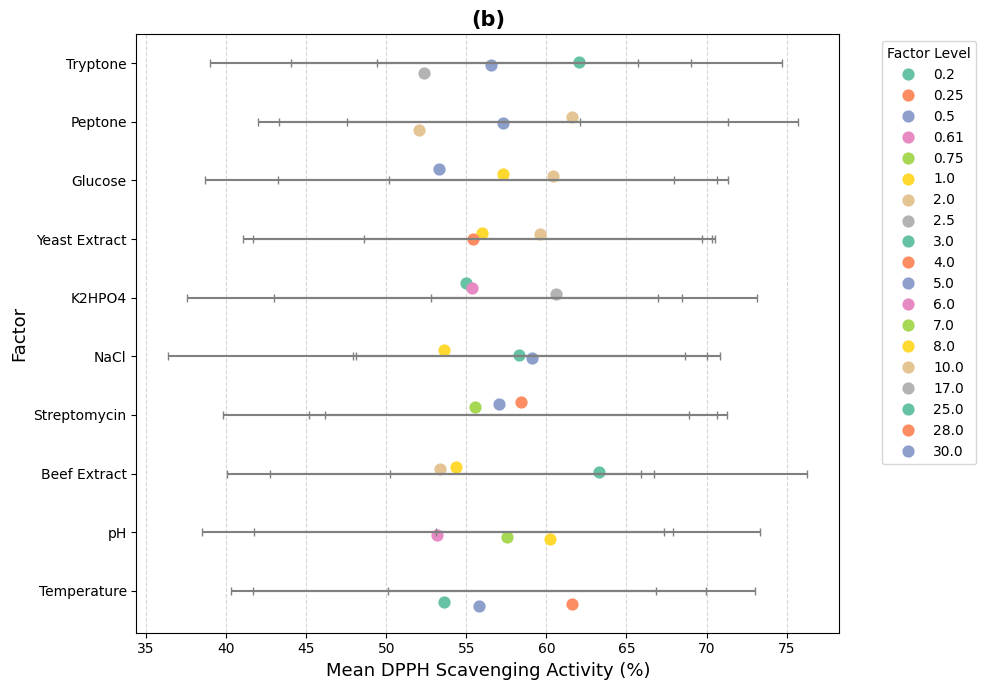

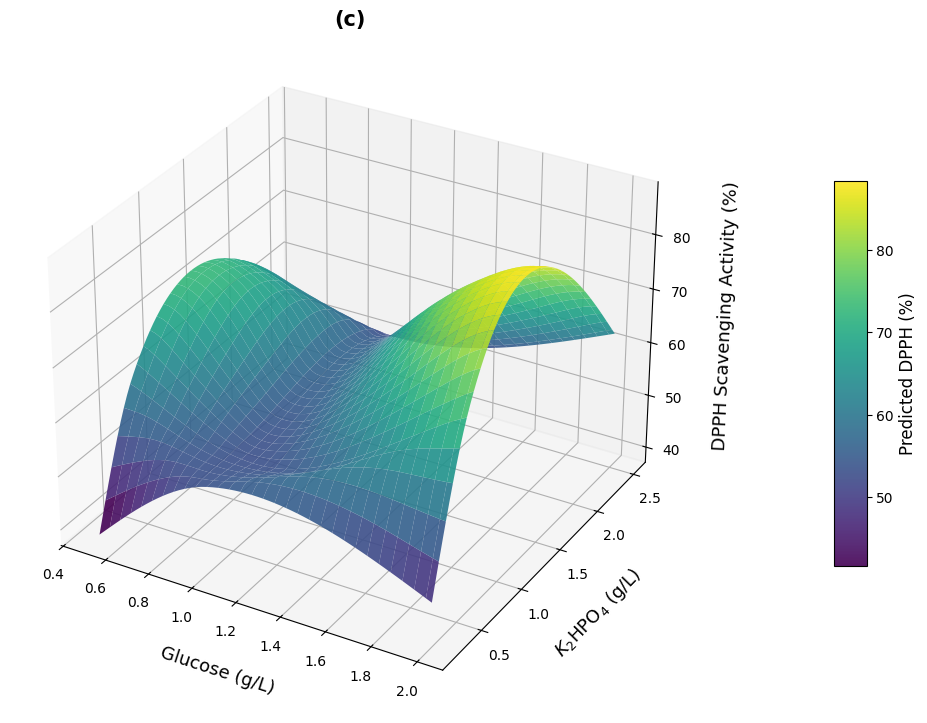

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# ==========================
# Load and clean the dataset
# ==========================
file_path = 'DPPH Scavenging percentage for L81.xlsx'
df = pd.read_excel(file_path, sheet_name="Sheet1")

# Strip any leading/trailing spaces in the column names
df.columns = df.columns.str.strip()

# Rename columns for easier reference
df = df.rename(columns={
    "Media name": "MC",
    "Glucose   (g/L)": "Glucose",
    "K2HPO4(g/L)": "K2HPO4",
    "Tryptone (g/L)": "Tryptone",
    "Peptone(g/L)": "Peptone",
    "Yeast extract (g/L)": "Yeast Extract",
    "NaCl (g/L)": "NaCl",
    "Streptomycin (g/L)": "Streptomycin",
    "Beef Extract  (g/L)": "Beef Extract",
    "PH": "pH",
    "Temperature (oC)": "Temperature",
    "DPPH Scavenging activity %": "DPPH"
})

df = df.dropna(subset=["DPPH"])

# ==========================
# Figure 3A: Distribution (box + points)
# ==========================
plt.figure(figsize=(6,5))

# Publication-friendly high-contrast palette
box_color = "#003f5c"       # dark navy blue
point_color = "#ff6361"     # vivid coral/red

sns.boxplot(
    y=df["DPPH"],
    color=box_color,
    width=0.4,
    fliersize=0
)

sns.stripplot(
    y=df["DPPH"],
    color=point_color,
    size=4,
    jitter=True,
    alpha=0.9
)

plt.ylabel("DPPH Scavenging Activity (%)", fontsize=13)
plt.title("(a)", fontsize=15, weight="bold")  # Only panel label here
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.savefig("Figure3A_Distribution.png", dpi=600)
plt.show()

# ==========================
# Figure 3B: Dot-Whisker Main Effects
# ==========================
factors = ["Tryptone", "Peptone", "Glucose", "Yeast Extract", 
           "K2HPO4", "NaCl", "Streptomycin", "Beef Extract",
           "pH", "Temperature"]

# Calculate mean and std for each factor level
summary_list = []
for factor in factors:
    grouped = df.groupby(factor)["DPPH"].agg(["mean", "std"]).reset_index()
    grouped["Factor"] = factor
    grouped.rename(columns={factor: "Level"}, inplace=True)
    summary_list.append(grouped)

summary_df = pd.concat(summary_list, ignore_index=True)

plt.figure(figsize=(10,7))
sns.pointplot(
    data=summary_df,
    x="mean", y="Factor", hue="Level",
    dodge=0.5, join=False, palette="Set2",
    errwidth=1, errorbar=None  # we'll add errorbars manually
)

# Add error bars manually
for i, row in summary_df.iterrows():
    plt.errorbar(
        x=row["mean"], y=row["Factor"],
        xerr=row["std"], fmt="none", ecolor="gray", capsize=3
    )

plt.xlabel("Mean DPPH Scavenging Activity (%)", fontsize=13)
plt.ylabel("Factor", fontsize=13)
plt.title("(b)", fontsize=15, weight="bold")  # Only panel label here
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.legend(title="Factor Level", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("Figure3B_DotWhisker.png", dpi=300, bbox_inches="tight")
plt.show()

# ==========================
# Figure 3C: 3D Response Surface (Glucose × K2HPO4)
# ==========================
x = df["Glucose"]
y = df["K2HPO4"]
z = df["DPPH"]

# Create interpolation grid
grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 60),
    np.linspace(y.min(), y.max(), 60)
)
grid_z = griddata((x, y), z, (grid_x, grid_y), method="cubic")

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap="viridis", edgecolor="none", alpha=0.9)

ax.set_xlabel("Glucose (g/L)", fontsize=13, labelpad=12)
ax.set_ylabel(r"$K_2$HPO$_4$ (g/L)", fontsize=13, labelpad=12)  # LaTeX for K2HPO4
ax.set_zlabel("DPPH Scavenging Activity (%)", fontsize=13, labelpad=12)
ax.set_title("(c)", fontsize=15, weight="bold")  # Only panel label here

cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=12, pad=0.15)
cbar.set_label("Predicted DPPH (%)", fontsize=12)

plt.tight_layout()
plt.savefig("Figure3C_ResponseSurface.png", dpi=600, bbox_inches="tight")
plt.show()
